# Controller Monitoring

Visualize controller performance on mainnet

In [1]:
import os
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from web3 import Web3, HTTPProvider

size = 15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,12),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

Gather Data

In [2]:
# Need an archive node
ETH_RPC_URL=os.environ['ETH_RPC_URL']

In [3]:
# UpdateRedemptionRate events come from the rate setter
GEB_RRFM_SETTER="0x7Acfc14dBF2decD1c9213Db32AE7784626daEb48"

# Will retrive sg, ag, pscl from rate calc
GEB_RRFM_CALCULATOR="0xddA334de7A9C57A641616492175ca203Ba8Cf981"
# new scaled controller
NEW_GEB_RRFM_CALCULATOR="0x5CC4878eA3E6323FdA34b3D28551E1543DEe54C6"


In [4]:
# import abis
from abis.abis import GEB_RRFM_SETTER_ABI, GEB_RRFM_CALCULATOR_ABI

In [5]:
w3 = Web3(Web3.HTTPProvider(ETH_RPC_URL, request_kwargs={"timeout": 10}))
rate_setter = w3.eth.contract(address=GEB_RRFM_SETTER, abi=GEB_RRFM_SETTER_ABI)
rate_calc = w3.eth.contract(address=GEB_RRFM_CALCULATOR, abi=GEB_RRFM_CALCULATOR_ABI)
new_rate_calc = w3.eth.contract(address=NEW_GEB_RRFM_CALCULATOR, abi=GEB_RRFM_CALCULATOR_ABI)

calc_deploy_block = 14226200
new_calc_deploy_block = 15046690

first_block = calc_deploy_block
last_block = 'latest'

update_rr_filter = {'fromBlock': first_block, 'toBlock': last_block, 'address': GEB_RRFM_SETTER,
                     'topics': ['0x16abce12916e67b821a9cdabe7103d806d6f4280a69d5830925b3e34c83f52a8']}
logs = w3.eth.get_logs(update_rr_filter)

results = []
for log in logs:
    event = []
    p_log = rate_setter.events.UpdateRedemptionRate().processLog(log)
    
    event.append(p_log['args']['marketPrice'])
    event.append(p_log['args']['redemptionPrice'])
    event.append(p_log['args']['redemptionRate'])
    event.append(p_log['transactionHash'].hex())
    event.append(p_log['address'])
    event.append(p_log['blockNumber'])
    ts = w3.eth.get_block(p_log['blockNumber'])['timestamp']

    # Rate calc variables
    if p_log['blockNumber'] < new_calc_deploy_block: 
        current_rate_calc = rate_calc
    else:
        current_rate_calc = new_rate_calc
        
    prop_term = current_rate_calc.caller(block_identifier=p_log['blockNumber']).getLastProportionalTerm()
    integral_term = current_rate_calc.caller(block_identifier=p_log['blockNumber']).getLastIntegralTerm()
    sg = current_rate_calc.caller(block_identifier=p_log['blockNumber']).sg()
    ag = current_rate_calc.caller(block_identifier=p_log['blockNumber']).ag()
    pscl = current_rate_calc.caller(block_identifier=p_log['blockNumber']).pscl()

    event.append(ts)
    event.append(prop_term)
    event.append(integral_term)
    event.append(sg)
    event.append(ag)
    event.append(pscl)
    results.append(event)

Create dataframe

In [6]:
df = pd.DataFrame(results, columns=['marketPrice', 'redemptionPrice', 'redemptionRate', 'transactionHash',\
                                    'address', 'blockNumber', 'ts', 'prop_term', 'integral_term', 'sg', 'ag', 'pscl'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   marketPrice      269 non-null    object
 1   redemptionPrice  269 non-null    object
 2   redemptionRate   269 non-null    object
 3   transactionHash  269 non-null    object
 4   address          269 non-null    object
 5   blockNumber      269 non-null    int64 
 6   ts               269 non-null    int64 
 7   prop_term        269 non-null    object
 8   integral_term    269 non-null    object
 9   sg               269 non-null    int64 
 10  ag               269 non-null    int64 
 11  pscl             269 non-null    object
dtypes: int64(4), object(8)
memory usage: 25.3+ KB


In [8]:
df['timestamp'] = pd.to_datetime(df['ts'], unit='s')

In [9]:
df = df.set_index('timestamp')

In [10]:
# these are delta rates, not per-second rates
df['p_rate_delta'] = (df['prop_term'] * df['sg'])/1e18
df['i_rate_delta'] = (df['integral_term'] * df['ag'])/1e18

# create total per-second rate
df['total_rate'] = (1e27 + df['p_rate_delta'] + df['i_rate_delta'])

# convert these to per-second rates
df['p_rate'] = 1e27 + df['p_rate_delta']
df['i_rate'] = 1e27 + df['i_rate_delta']

In [11]:
# calculate annual rates
df['redemptionRate_apy'] = (df['redemptionRate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
df['total_rate_apy'] = (df['total_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
df['p_rate_apy'] = (df['p_rate'].apply(lambda x: Decimal(int(x))).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
df['i_rate_apy'] = (df['i_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100

In [12]:
df['apy_diff'] = df['redemptionRate_apy'] - df['total_rate_apy']

Convert for plotting

In [13]:
df['marketPrice'] = df['marketPrice'].apply(lambda x: int(x)/1e27)
df['redemptionPrice'] = df['redemptionPrice'].apply(lambda x: int(x)/1e27)

In [14]:
df['total_rate_apy'] = df['total_rate_apy'].apply(float)
df['p_rate_apy'] = df['p_rate_apy'].apply(float)
df['i_rate_apy'] = df['i_rate_apy'].apply(float)

df['p_rate_delta'] = df['p_rate_delta'].apply(float)
df['i_rate_delta'] = df['i_rate_delta'].apply(float)

Plot total, p and i rates

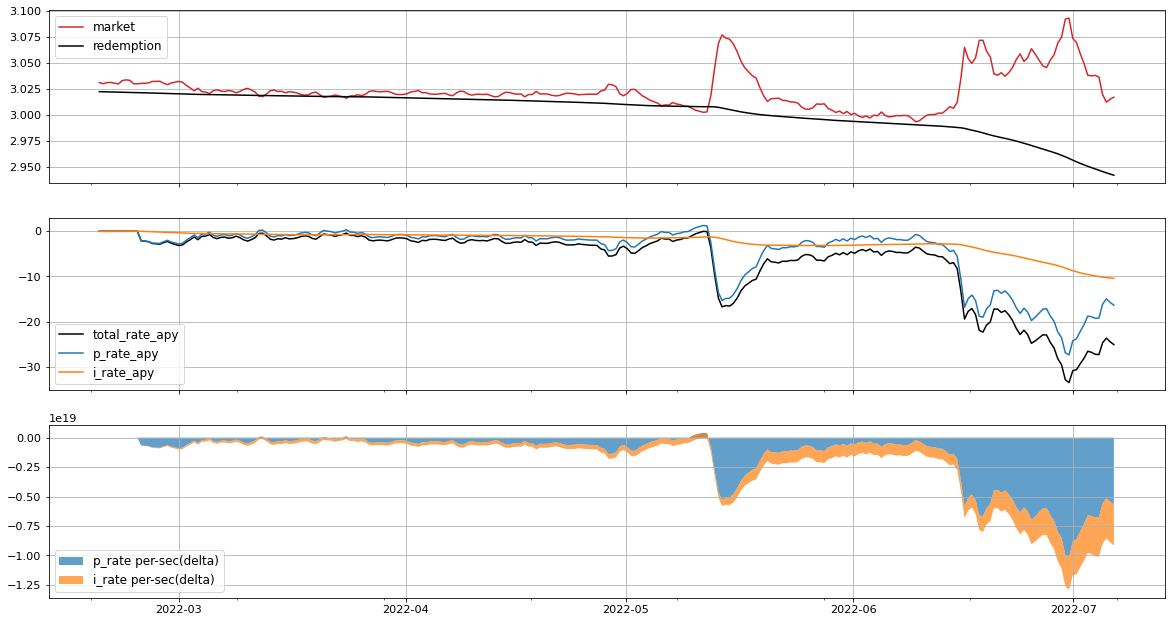

In [15]:
fig, ax = plt.subplots(3, 1, sharex=True)
#ax[0].plot(df[['marketPrice', 'redemptionPrice']], label=['market', 'redemption'], colors=['#d62728', 'black'])
ax[0].plot(df[['marketPrice']], label='market', color='#d62728')
ax[0].plot(df[['redemptionPrice']], label='redemption', color='black')
ax[0].legend()
ax[0].grid()


df[['total_rate_apy', 'p_rate_apy', 'i_rate_apy']].plot(ax=ax[1], color=['black', '#1f77b4', '#ff7f0e'])
ax[1].grid()

ax[2].stackplot(df.index, df['p_rate_delta'], df['i_rate_delta'], baseline='zero', alpha=0.7,
                labels=['p_rate per-sec(delta)', 'i_rate per-sec(delta)'])
ax[2].legend(loc='lower left')
ax[2].grid()

plt.savefig('output/controller_monitoring.png', facecolor='white', transparent=False)
plt.show()

In [16]:
df.to_csv('output/final_data.csv')

In [17]:
# get defauly color cycle
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
